In [6]:
import numpy as np
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go

from ipa.domination import non_dominated
from ipa.GenerateReferencePoints import generate_points, rotate, rotate_in, rotate_out
from ipa.scalarization import ReferencePointASF
from ipa.hull_optimization import hull_opt, DSS_hull_gen
from ipa.selection import DSS_scipy, angle_distance
from scipy.spatial import ConvexHull

from functools import partial

In [7]:
dataT = pd.read_csv("../data/forest.csv")
# Calculate correlation between columns of data

corr = dataT.corr()
corr

,Rev,HA,Carb,DW
Rev,1.000000,-0.629984,-0.924207,-0.719328
HA,-0.629984,1.000000,0.557433,0.875267
Carb,-0.924207,0.557433,1.000000,0.747950
DW,-0.719328,0.875267,0.747950,1.000000


In [8]:
# Objs chosen based on correlation matrix

dataT = dataT[["Rev", "HA", "Carb"]]

dataT = dataT[non_dominated(-dataT.to_numpy())]

ex.scatter_3d(
    dataT,
    x="Rev",
    y="HA",
    z="Carb",
    width=800,
    height=800,
)

In [9]:
# Use distance based subset selection to select reference points iteratively


# Convert to minimization problem, and normalize
data = -dataT
data = (data - data.min()) / (data.max() - data.min())

ideal = np.array((0, 0, 0))
nadir = np.array((1, 1, 1))

data_np = data.to_numpy()

asf_func = ReferencePointASF(preferential_factors=1, utopian_point=ideal, nadir=nadir, rho=0)


def ref_solver(reference_point):
    asf_vals = asf_func(data_np, reference_point)
    index = np.argmin(asf_vals)
    return data_np[index], asf_vals[index]


bad_reference_checker = partial(angle_distance, threshold=1)  # 2 degrees

In [10]:
max_iterations = 50
evaluated_refs, found_sols, k_vals, success, reference_hull, bad_hulls = hull_opt(
    generation_method=DSS_hull_gen,
    asf_solver=ref_solver,
    num_objectives=3,
    bad_reference_check=bad_reference_checker,
    max_iterations=max_iterations,
    threshold=0.05,
)

6


  0%|          | 0/44 [00:00<?, ?it/s]/Users/bhupindersaini/Projects/iterative-pareto-approximator/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/bhupindersaini/Projects/iterative-pareto-approximator/.venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

100%|██████████| 44/44 [00:33<00:00,  1.33it/s]


In [11]:
reference_ = rotate_out(reference_hull.points[reference_hull.vertices])
bad_hulls_ = [rotate_out(hull.points[hull.vertices]) for hull in bad_hulls]

In [12]:
# Plot the data and reference points

fig = ex.scatter_3d(
    x=[ideal[0]],
    y=[ideal[1]],
    z=[ideal[2]],
    width=800,
    height=700,
)

fig.add_scatter3d(
    x=data_np[:, 0],
    y=data_np[:, 1],
    z=data_np[:, 2],
    mode="markers",
    name="Solutions",
    opacity=0.5,
    marker=dict(size=3, color=found_sols),
)

fig.update(layout_coloraxis_showscale=False)

# Add reference points hull


fig.add_mesh3d(
    x=reference_[:, 0],
    y=reference_[:, 1],
    z=reference_[:, 2],
    opacity=0.5,
    color="lightblue",
)

# Add bad reference points hulls

for i, hull in enumerate(bad_hulls_):
    fig.add_mesh3d(
        x=hull[:, 0],
        y=hull[:, 1],
        z=hull[:, 2],
        opacity=0.5,
        color=i % 10,
    )

# Add evaluated reference points

evaluated_refs = np.array(evaluated_refs)

fig.add_scatter3d(
    x=evaluated_refs[:, 0],
    y=evaluated_refs[:, 1],
    z=evaluated_refs[:, 2],
    mode="markers",
    name="Evaluated Reference Points",
    marker=dict(size=5, color="black"),
)

# Add found solutions
fig.add_scatter3d(
    x=found_sols[:, 0],
    y=found_sols[:, 1],
    z=found_sols[:, 2],
    mode="markers",
    name="Found Solutions",
    marker=dict(size=5, color="green"),
)

# Add ideal and nadir points

fig.add_trace(
    go.Scatter3d(x=[ideal[0]], y=[ideal[1]], z=[ideal[2]], mode="markers", name="Ideal")
)

fig.add_trace(
    go.Scatter3d(x=[nadir[0]], y=[nadir[1]], z=[nadir[2]], mode="markers", name="Nadir")
)


fig.layout.scene.camera.projection.type = "orthographic"

fig

In [13]:
ex.scatter_3d(
    x=evaluated_refs[:, 0],
    y=evaluated_refs[:, 1],
    z=evaluated_refs[:, 2],
)

In [14]:
evaluated_refs_ = rotate_in(evaluated_refs)
fig = ex.scatter(
    x=evaluated_refs_[:, 0],
    y=evaluated_refs_[:, 1],
)

fig.add_scatter(
    x=reference_hull.points[reference_hull.vertices][:, 0],
    y=reference_hull.points[reference_hull.vertices][:, 1],
)

for i, hull in enumerate(bad_hulls):
    fig.add_scatter(
        x=hull.points[hull.vertices][:, 0],
        y=hull.points[hull.vertices][:, 1],
        marker=dict(color=i % 10),
    )

fig

In [15]:
np.where(evaluated_refs == 4)

(array([], dtype=int64), array([], dtype=int64))

In [16]:
def moving_sum(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

In [17]:
ex.line(moving_sum(success, 100))

In [18]:
import pandas as pd

In [19]:
success.astype(int)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0])

<Axes: >

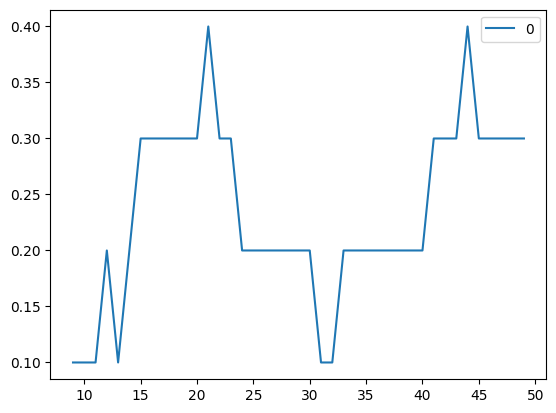

In [20]:
success_df = pd.DataFrame(success.astype(int))
success_df.rolling(10).mean().plot()